In [25]:
import tensorflow as tf
print(tf.__version__)  # Print TensorFlow version

2.16.1


In [26]:
#pip install tensorflow==2.12.0

In [27]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/state-farm-distracted-driver-detection/imgs/train",
    shuffle=True,
    batch_size=32,
    image_size=(224, 224),
)

labels = dataset.class_names
labels

Found 22424 files belonging to 10 classes.


['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [28]:
import numpy as np

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    break

(32, 224, 224, 3)
[9 1 9 8 0 1 2 3 0 3 3 0 8 5 3 1 6 0 1 2 1 5 4 1 6 4 0 1 3 3 2 7]


In [29]:
# train test split
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))
train_size, test_size

(560, 140)

In [30]:
def get_dataset_partisions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * len(ds))
    test_size = int(test_split * len(ds))
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = test_ds.skip(test_size)
    test_ds = test_ds.take(test_size)
    return train_ds, test_ds, val_ds

In [31]:
train_ds, test_ds, val_ds = get_dataset_partisions_tf(dataset)
len(train_ds), len(test_ds), len(val_ds)

(560, 140, 1)

In [32]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255)
])

In [33]:
# train using ResNet50
base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg',
    classifier_activation='softmax',
    classes=len(labels)
)

In [34]:
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = resize_and_rescale(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(labels), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,828,362 (90.90 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - accuracy: 0.6581 - loss: 1.0663 - val_accuracy: 0.9375 - val_loss: 0.1701
Epoch 2/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9375 - loss: 0.2199 - val_accuracy: 1.0000 - val_loss: 0.0179
Epoch 3/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 102s 148ms/step - accuracy: 0.9582 - loss: 0.1424 - val_accuracy: 1.0000 - val_loss: 0.0324
Epoch 4/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.9711 - loss: 0.1035 - val_accuracy: 1.0000 - val_loss: 0.0076
Epoch 5/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9786 - loss: 0.0715 - val_accuracy: 1.0000 - val_loss: 0.0313
Epoch 6/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.9677 - loss: 0.0966 - val_accuracy: 1.0000 - val_loss: 0.0197
Epoch 7/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9832 - loss: 0.0534 - val_accuracy: 0.9688 - val_loss: 0.0382
Epoch 8/10
560/560 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - accuracy: 0.9822 - loss: 0.0538 

In [35]:
model.evaluate(test_ds)

140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.9937 - loss: 0.0185


[0.017837049439549446, 0.9930803775787354]

In [36]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_1.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch


predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image most likely belongs to c5 with a 73.10 percent confidence.


In [37]:
# predict with new images
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100000.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to c3 with a 73.10 percent confidence.


In [38]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100005.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to c7 with a 68.03 percent confidence.


In [39]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100018.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to c8 with a 64.07 percent confidence.


In [40]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100025.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to c7 with a 73.11 percent confidence.


In [41]:
import numpy as np

img = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100012.jpg', target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch
predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to c9 with a 70.34 percent confidence.


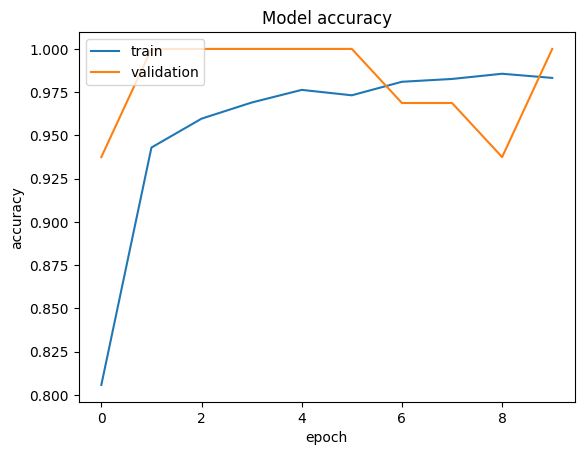

In [42]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

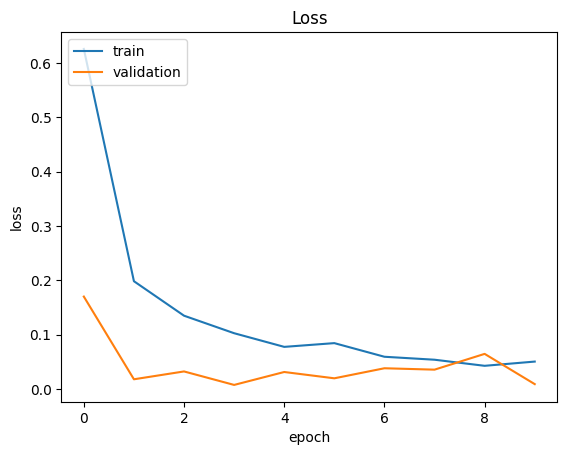

In [43]:
# plot accuracy and loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
model.save('DL_model_avg_25.h5')

In [49]:
from tensorflow.keras.models import save_model
save_model(model, 'Epoch_10_DL_model_resnet50.keras')

In [50]:
save_model(model, "Epoch_10_DL_model.h5", save_format="h5")

In [47]:
#import tensorflow as tf
print(tf.__version__)  # Print TensorFlow version

2.16.1


In [48]:
print(labels)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
